In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as dt
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [ ]:
fpt = pd.read_csv('FPT.csv')
msn = pd.read_csv('MSN.csv')
pnj = pd.read_csv('PNJ.csv')
vic = pd.read_csv('VIC.csv')
list_df = [fpt,msn,pnj,vic]
ticker = ['fpt','msn','pnj','vic']

## Check some information about datasets

In [ ]:
fpt.head()

,Ticker,Date/Time,Open,High,Low,Close,Volume,Open Interest
0,FPT,12/25/2018 9:15,30.89,30.89,30.89,30.89,35410,0
1,FPT,12/25/2018 9:16,30.81,30.81,30.81,30.81,190,0
2,FPT,12/25/2018 9:17,30.74,30.81,30.74,30.74,1120,0
3,FPT,12/25/2018 9:18,30.74,30.74,30.74,30.74,2120,0
4,FPT,12/25/2018 9:19,30.74,30.74,30.74,30.74,22500,0


In [ ]:
fpt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97406 entries, 0 to 97405
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Ticker         97406 non-null  object 
 1   Date/Time      97406 non-null  object 
 2   Open           97406 non-null  float64
 3   High           97406 non-null  float64
 4   Low            97406 non-null  float64
 5   Close          97406 non-null  float64
 6   Volume         97406 non-null  int64  
 7   Open Interest  97406 non-null  int64  
dtypes: float64(4), int64(2), object(2)
memory usage: 5.9+ MB


In [ ]:
fpt.describe()

,Open,High,Low,Close,Volume,Open Interest
count,97406.000000,97406.000000,97406.000000,97406.000000,9.740600e+04,97406.0
mean,45.071630,45.090138,45.051430,45.071631,8.044173e+03,0.0
std,6.359803,6.364950,6.354245,6.359799,1.753203e+04,0.0
min,30.250000,30.250000,30.220000,30.250000,1.000000e+01,0.0
25%,39.740000,39.740000,39.700000,39.740000,7.500000e+02,0.0
50%,46.950000,46.950000,46.950000,46.950000,2.960000e+03,0.0
75%,49.200000,49.250000,49.170000,49.200000,8.960000e+03,0.0
max,58.400000,58.500000,58.400000,58.400000,1.255930e+06,0.0


In [ ]:
fpt.nunique()

Ticker               1
Date/Time        97406
Open               802
High               800
Low                802
Close              802
Volume            6221
Open Interest        1
dtype: int64

In [ ]:
flag = 0
for i in range(len(list_df)):
  if list_df[i].isnull().sum().any():
    flag+=1
    print(ticker[i] + " dataframe has null values")
if flag == 0:
  print('No dataframe has null values')

No dataframe has null values


## Prepare functions for training model

In [ ]:
def split_date(df):
  df['Date/Time'] = pd.to_datetime(df['Date/Time'])
  df['Date'] = [d.date() for d in df['Date/Time']]
  return df

In [ ]:
def get_close_price(df):
  return df.groupby('Date')['Close'].last().reset_index(name='Close')

In [ ]:
from sklearn.preprocessing import MinMaxScaler
normalizer = MinMaxScaler(feature_range=(0,1))
def create_dataset_for_training(close_price, list_date):
  X,Y = [],[]
  for i in range(len(list_date)):
    if i + 100 < len(list_date):
      X.append(close_price_scaled[i:i+100,0])
      Y.append(close_price_scaled[i+100,0])
  X = np.array(X)
  Y = np.array(Y)
  return np.array(X), np.array(Y)

In [ ]:
def train_test_split_dataset(X,Y, test_size):
  X_train, Y_train = X[:len(X) - test_size], Y[:len(Y) - test_size]
  X_test, Y_test = X[len(X) - test_size:], Y[len(Y) - test_size:]
  return X_train, X_test, Y_train, Y_test

In [ ]:
def LSTM_model_building(X_train):
  model = Sequential()
  model.add(LSTM(100, return_sequences=True, input_shape=(X_train.shape[1], 1)))
  model.add(LSTM(100, return_sequences=False))
  model.add(Dense(25))
  model.add(Dense(1))
  return model

## Predict FPT stock price

In [ ]:
# prepare data for training
new_df = split_date(fpt)
close_price_df = get_close_price(new_df)

# normalize close price
close_price = close_price_df[['Close']].values
close_price_scaled = normalizer.fit_transform(np.array(close_price).reshape(-1,1))

list_date = close_price_df.Date.values

X, Y = create_dataset_for_training(close_price_scaled, list_date)
test_size = 60  # get last 60 day for testing
X_train,X_test,Y_train,Y_test = train_test_split_dataset(X,Y,test_size)

#reshape data to fit into LSTM model
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [ ]:
# create LSTM model
model = LSTM_model_building(X_train)
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 100)          40800     
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 25)                2525      
                                                                 
 dense_1 (Dense)             (None, 1)                 26        
                                                                 
Total params: 123,751
Trainable params: 123,751
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
# training model with adam optimizer and mean square error loss function
model.compile(loss='mean_squared_error',optimizer='adam')
model.fit(X_train,Y_train,validation_data=(X_test,Y_test),epochs=100,batch_size=64)

Epoch 1/100
6/6 [==============================] - 5s 300ms/step - loss: 0.0969 - val_loss: 0.0105
Epoch 2/100
6/6 [==============================] - 1s 159ms/step - loss: 0.0199 - val_loss: 0.0425
Epoch 3/100
6/6 [==============================] - 1s 161ms/step - loss: 0.0082 - val_loss: 0.0027
Epoch 4/100
6/6 [==============================] - 1s 173ms/step - loss: 0.0083 - val_loss: 0.0198
Epoch 5/100
6/6 [==============================] - 2s 279ms/step - loss: 0.0068 - val_loss: 0.0173
Epoch 6/100
6/6 [==============================] - 1s 184ms/step - loss: 0.0047 - val_loss: 0.0032
Epoch 7/100
6/6 [==============================] - 1s 172ms/step - loss: 0.0050 - val_loss: 0.0100
Epoch 8/100
6/6 [==============================] - 1s 161ms/step - loss: 0.0046 - val_loss: 0.0101
Epoch 9/100
6/6 [==============================] - 1s 156ms/step - loss: 0.0042 - val_loss: 0.0044
Epoch 10/100
6/6 [==============================] - 1s 180ms/step - loss: 0.0041 - val_loss: 0.0085
Epoch 11/

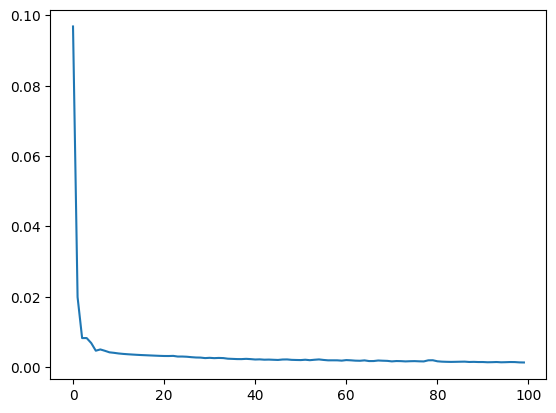

In [ ]:
# pLotting loss, it shows that loss has decreased significantly and model trained well
loss = model.history.history['loss']
plt.plot(loss)

The loss decreases significantly -> model trained well

In [ ]:
# predicitng on train and test data
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

2/2 [==============================] - 0s 26ms/step


In [ ]:
# inverse transform to get actual value
train_predict = normalizer.inverse_transform(train_predict)
test_predict = normalizer.inverse_transform(test_predict)

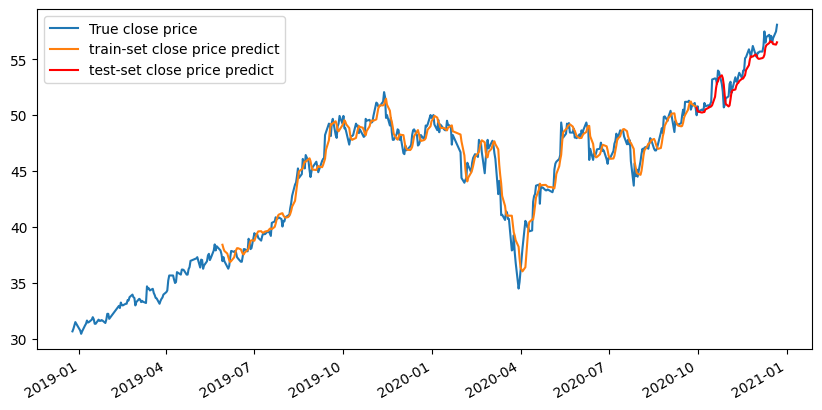

In [ ]:
# Visualize the prediction and the actual value
plt.figure(figsize=(10,5))
plt.plot(list_date,normalizer.inverse_transform(close_price_scaled),label='True close price')
plt.plot(list_date[100:len(list_date)-60],train_predict, label='train-set close price predict') # because first 100 days are used to training, so the model does not predict these days
plt.plot(list_date[len(list_date)-60:], test_predict, 'r', label='test-set close price predict')
plt.legend()
plt.gcf().autofmt_xdate()
plt.show()

The prediction look not bad ! So, I will use this model to predict next 60 days with sliding window algorithm

In [ ]:
next_N_days = 60

In [ ]:
# sliding window algorithm for predicting next N_days using last 100 stock price
def predict_future_close_stock_price(model,data, next_N_days):
  future_predict = []
  i = 0
  while (i < next_N_days):
    last_100_close_price = np.array(data[i:])
    last_100_close_price = last_100_close_price.reshape(1,-1)
    last_100_close_price = last_100_close_price.reshape((1, 100, 1))
    y_pred = model.predict(last_100_close_price)
    data = np.append(data, y_pred[0].tolist())
    future_predict.extend(y_pred[0].tolist())
    i = i + 1
  return future_predict

last_100_close_price = np.array(close_price_scaled[-100:]) # get last 100 close price for future prediction
predict_future_close_price = predict_future_close_stock_price(model, last_100_close_price, next_N_days)

1/1 [==============================] - 0s 23ms/step


In [ ]:
list_next_N_dates = [list_date[-1] + dt.timedelta(days=x) for x in range(1,1 + next_N_days)]

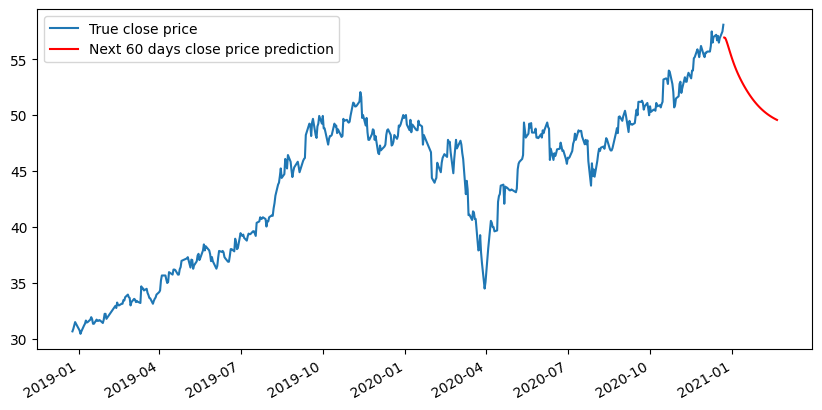

In [ ]:
# plotting the next 60 days prediction
plt.figure(figsize=(10,5))
plt.plot(list_date,normalizer.inverse_transform(close_price_scaled),label='True close price')
plt.plot(list_next_N_dates,normalizer.inverse_transform(np.array(predict_future_close_price).reshape(-1,1)), 'r',label='Next {0} days close price prediction'.format(next_N_days))
plt.legend()
plt.gcf().autofmt_xdate()
plt.show()

I think this LSTM model is not bad, so I will use to predict the next 30 days's stock price of MSN, PNJ and VIC ticker

## Predict MSN stock price

Epoch 1/100
10/10 [==============================] - 5s 228ms/step - loss: 0.0521 - val_loss: 0.0294
Epoch 2/100
10/10 [==============================] - 2s 166ms/step - loss: 0.0095 - val_loss: 0.0102
Epoch 3/100
10/10 [==============================] - 2s 167ms/step - loss: 0.0050 - val_loss: 0.0157
Epoch 4/100
10/10 [==============================] - 2s 164ms/step - loss: 0.0029 - val_loss: 0.0139
Epoch 5/100
10/10 [==============================] - 2s 215ms/step - loss: 0.0023 - val_loss: 0.0134
Epoch 6/100
10/10 [==============================] - 2s 191ms/step - loss: 0.0023 - val_loss: 0.0131
Epoch 7/100
10/10 [==============================] - 2s 167ms/step - loss: 0.0021 - val_loss: 0.0122
Epoch 8/100
10/10 [==============================] - 2s 169ms/step - loss: 0.0021 - val_loss: 0.0114
Epoch 9/100
10/10 [==============================] - 2s 163ms/step - loss: 0.0020 - val_loss: 0.0114
Epoch 10/100
10/10 [==============================] - 2s 162ms/step - loss: 0.0020 - val_lo

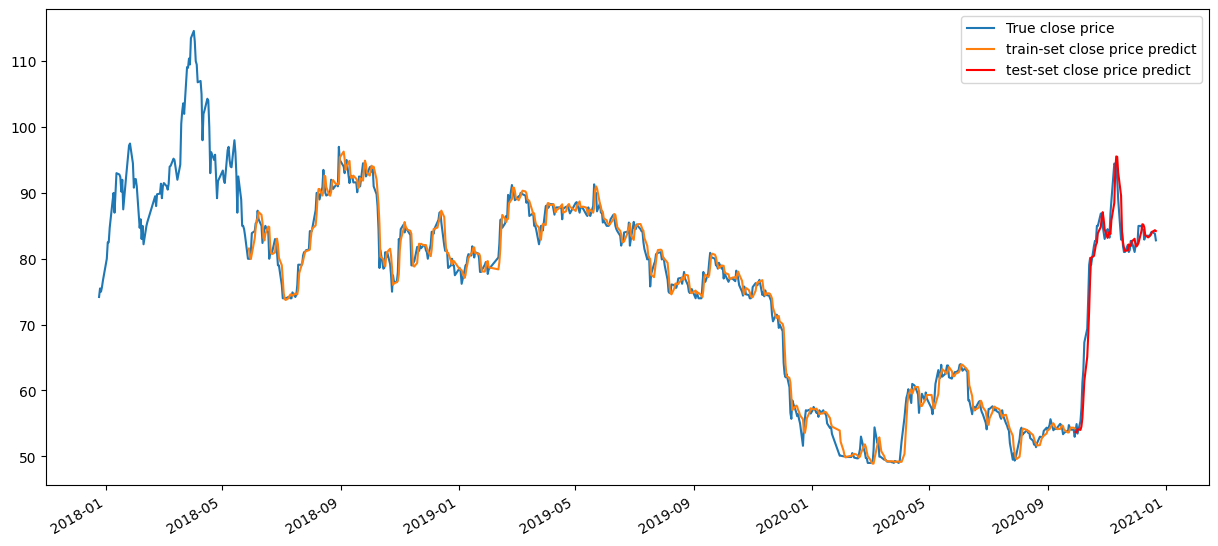

In [ ]:
# prepare data for training
new_df = split_date(msn)
close_price_df = get_close_price(new_df)

# normalize close price
close_price = close_price_df[['Close']].values
close_price_scaled = normalizer.fit_transform(np.array(close_price).reshape(-1,1))

list_date = close_price_df.Date.values

X, Y = create_dataset_for_training(close_price_scaled, list_date)
test_size =  60 # get last 60 day for testing
X_train,X_test,Y_train,Y_test = train_test_split_dataset(X,Y,test_size)

#reshape data to fit into LSTM model
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

# create LSTM model
model = LSTM_model_building(X_train)

# training model with adam optimizer and mean square error loss function
model.compile(loss='mean_squared_error',optimizer='adam')
model.fit(X_train,Y_train,validation_data=(X_test,Y_test),epochs=100,batch_size=64)

# predicitng on train and test data
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# inverse transform to get actual value
train_predict = normalizer.inverse_transform(train_predict)
test_predict = normalizer.inverse_transform(test_predict)

# Visualize the prediction and the actual value
plt.figure(figsize=(15,7))
plt.plot(list_date,normalizer.inverse_transform(close_price_scaled),label='True close price')
plt.plot(list_date[100:len(list_date)-60],train_predict, label='train-set close price predict')
plt.plot(list_date[len(list_date)-60:], test_predict, 'r', label='test-set close price predict')
plt.legend()
plt.gcf().autofmt_xdate()
plt.show()

1/1 [==============================] - 0s 22ms/step


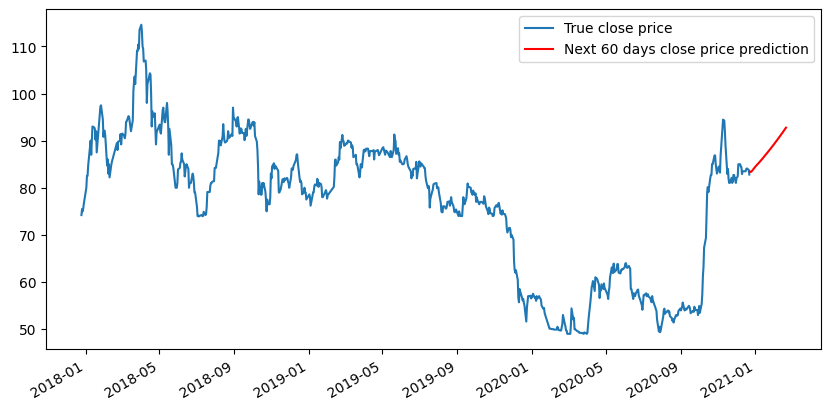

In [ ]:
# predict close stock price in next N days
last_100_close_price = np.array(close_price_scaled[-100:]) # get last 30 close price for future prediction
predict_future_close_price = predict_future_close_stock_price(model, last_100_close_price, next_N_days)

list_next_N_dates = [list_date[-1] + dt.timedelta(days=x) for x in range(1,1+next_N_days)]

# plotting the next N days prediction
plt.figure(figsize=(10,5))
plt.plot(list_date,normalizer.inverse_transform(close_price_scaled),label='True close price')
plt.plot(list_next_N_dates,normalizer.inverse_transform(np.array(predict_future_close_price).reshape(-1,1)), 'r',label='Next {0} days close price prediction'.format(next_N_days))
plt.legend()
plt.gcf().autofmt_xdate()
plt.show()

## Predict PNJ stock price

Epoch 1/100
9/9 [==============================] - 5s 273ms/step - loss: 0.0466 - val_loss: 0.0184
Epoch 2/100
9/9 [==============================] - 2s 207ms/step - loss: 0.0117 - val_loss: 0.0029
Epoch 3/100
9/9 [==============================] - 2s 170ms/step - loss: 0.0070 - val_loss: 0.0052
Epoch 4/100
9/9 [==============================] - 2s 172ms/step - loss: 0.0060 - val_loss: 0.0014
Epoch 5/100
9/9 [==============================] - 2s 174ms/step - loss: 0.0050 - val_loss: 0.0016
Epoch 6/100
9/9 [==============================] - 2s 182ms/step - loss: 0.0045 - val_loss: 0.0029
Epoch 7/100
9/9 [==============================] - 2s 170ms/step - loss: 0.0039 - val_loss: 0.0012
Epoch 8/100
9/9 [==============================] - 2s 219ms/step - loss: 0.0037 - val_loss: 0.0017
Epoch 9/100
9/9 [==============================] - 2s 214ms/step - loss: 0.0034 - val_loss: 0.0018
Epoch 10/100
9/9 [==============================] - 2s 176ms/step - loss: 0.0033 - val_loss: 0.0018
Epoch 11/

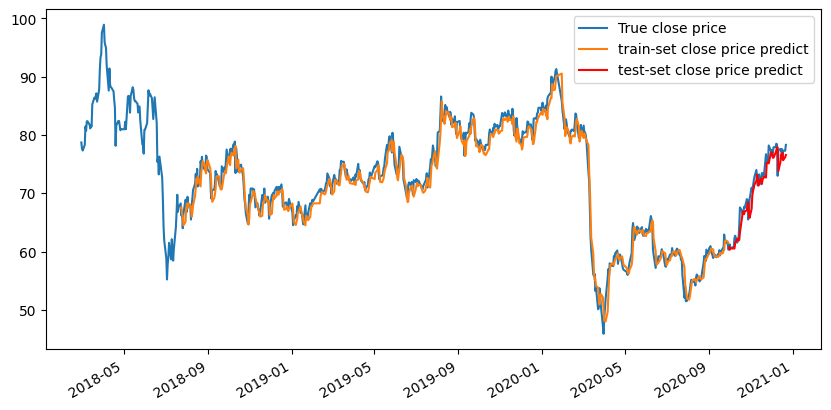

In [ ]:
# prepare data for training
new_df = split_date(pnj)
close_price_df = get_close_price(new_df)

# normalize close price
close_price = close_price_df[['Close']].values
close_price_scaled = normalizer.fit_transform(np.array(close_price).reshape(-1,1))

list_date = close_price_df.Date.values

X, Y = create_dataset_for_training(close_price_scaled, list_date)
test_size = 60 # get last 60 day for testing
X_train,X_test,Y_train,Y_test = train_test_split_dataset(X,Y,test_size)

#reshape data to fit into LSTM model
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

# create LSTM model
model = LSTM_model_building(X_train)

# training model with adam optimizer and mean square error loss function
model.compile(loss='mean_squared_error',optimizer='adam')
model.fit(X_train,Y_train,validation_data=(X_test,Y_test),epochs=100,batch_size=64)

# predicitng on train and test data
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# inverse transform to get actual value
train_predict = normalizer.inverse_transform(train_predict)
test_predict = normalizer.inverse_transform(test_predict)

# Visualize the prediction and the actual value
plt.figure(figsize=(10,5))
plt.plot(list_date,normalizer.inverse_transform(close_price_scaled),label='True close price')
plt.plot(list_date[100:len(list_date)-60],train_predict, label='train-set close price predict')
plt.plot(list_date[len(list_date)-60:], test_predict, 'r', label='test-set close price predict')
plt.legend()
plt.gcf().autofmt_xdate()
plt.show()

1/1 [==============================] - 0s 22ms/step


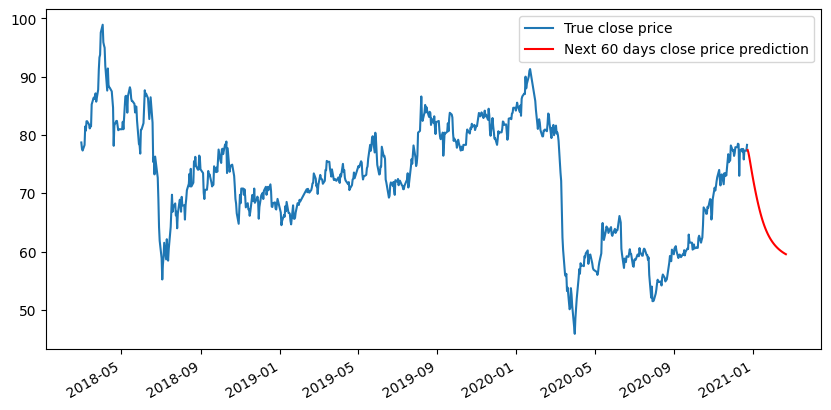

In [ ]:
# predict close stock price in next N days
last_100_close_price = np.array(close_price_scaled[-100:]) # get last 30 close price for future prediction
predict_future_close_price = predict_future_close_stock_price(model, last_100_close_price, next_N_days)

list_next_N_dates = [list_date[-1] + dt.timedelta(days=x) for x in range(1,1+next_N_days)]

# plotting the next 60 days prediction
plt.figure(figsize=(10,5))
plt.plot(list_date,normalizer.inverse_transform(close_price_scaled),label='True close price')
plt.plot(list_next_N_dates,normalizer.inverse_transform(np.array(predict_future_close_price).reshape(-1,1)), 'r',label='Next {0} days close price prediction'.format(next_N_days))
plt.legend()
plt.gcf().autofmt_xdate()
plt.show()

## Predict VIC stock price

Epoch 1/100
7/7 [==============================] - 4s 254ms/step - loss: 0.1276 - val_loss: 0.0041
Epoch 2/100
7/7 [==============================] - 1s 160ms/step - loss: 0.0212 - val_loss: 0.0035
Epoch 3/100
7/7 [==============================] - 1s 158ms/step - loss: 0.0081 - val_loss: 0.0032
Epoch 4/100
7/7 [==============================] - 1s 163ms/step - loss: 0.0070 - val_loss: 0.0038
Epoch 5/100
7/7 [==============================] - 1s 159ms/step - loss: 0.0067 - val_loss: 0.0023
Epoch 6/100
7/7 [==============================] - 2s 265ms/step - loss: 0.0056 - val_loss: 0.0027
Epoch 7/100
7/7 [==============================] - 1s 165ms/step - loss: 0.0052 - val_loss: 0.0020
Epoch 8/100
7/7 [==============================] - 1s 165ms/step - loss: 0.0045 - val_loss: 0.0031
Epoch 9/100
7/7 [==============================] - 1s 159ms/step - loss: 0.0049 - val_loss: 0.0021
Epoch 10/100
7/7 [==============================] - 1s 161ms/step - loss: 0.0043 - val_loss: 0.0035
Epoch 11/

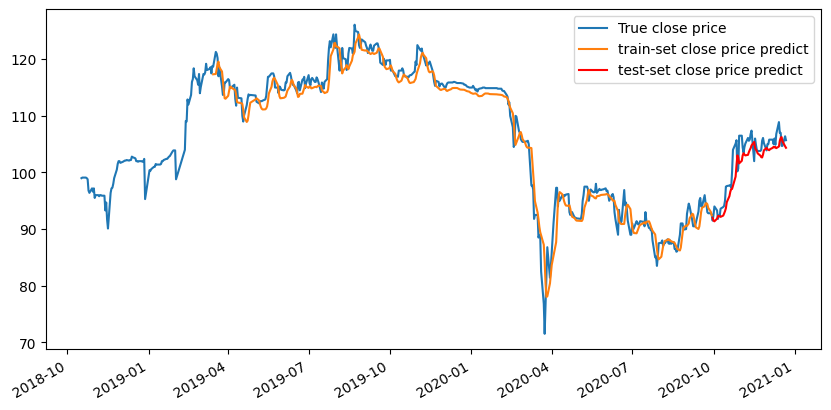

In [ ]:
# prepare data for training
new_df = split_date(vic)
close_price_df = get_close_price(new_df)

# normalize close price
close_price = close_price_df[['Close']].values
close_price_scaled = normalizer.fit_transform(np.array(close_price).reshape(-1,1))

list_date = close_price_df.Date.values

X, Y = create_dataset_for_training(close_price_scaled, list_date)
test_size = 60 # get last 60 day for testing
X_train,X_test,Y_train,Y_test = train_test_split_dataset(X,Y,test_size)

#reshape data to fit into LSTM model
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

# create LSTM model
model = LSTM_model_building(X_train)

# training model with adam optimizer and mean square error loss function
model.compile(loss='mean_squared_error',optimizer='adam')
model.fit(X_train,Y_train,validation_data=(X_test,Y_test),epochs=100,batch_size=64)

# predicitng on train and test data
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# inverse transform to get actual value
train_predict = normalizer.inverse_transform(train_predict)
test_predict = normalizer.inverse_transform(test_predict)

# Visualize the prediction and the actual value
plt.figure(figsize=(10,5))
plt.plot(list_date,normalizer.inverse_transform(close_price_scaled),label='True close price')
plt.plot(list_date[100:len(list_date)-60],train_predict, label='train-set close price predict')
plt.plot(list_date[len(list_date)-60:], test_predict, 'r', label='test-set close price predict')
plt.legend()
plt.gcf().autofmt_xdate()
plt.show()

1/1 [==============================] - 0s 29ms/step


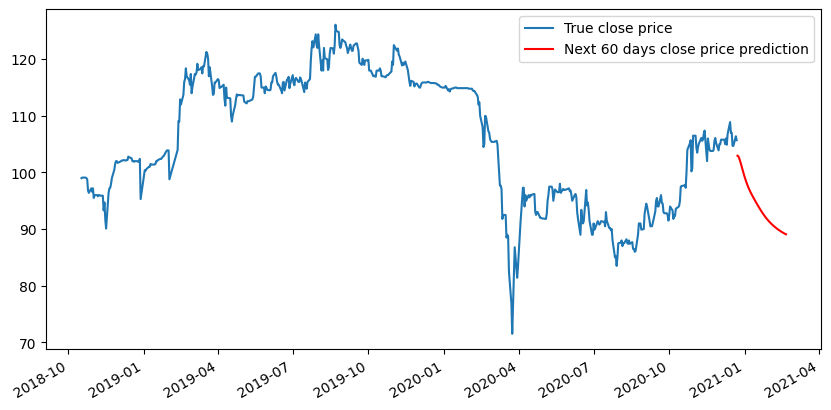

In [ ]:
# predict close stock price in next N days
last_300_close_price = np.array(close_price_scaled[-30:]) # get last 100 close price for future prediction
predict_future_close_price = predict_future_close_stock_price(model, last_100_close_price, next_N_days)

list_next_N_dates = [list_date[-1] + dt.timedelta(days=x) for x in range(1,1 + next_N_days)]

# plotting the next 60 days prediction
plt.figure(figsize=(10,5))
plt.plot(list_date,normalizer.inverse_transform(close_price_scaled),label='True close price')
plt.plot(list_next_N_dates,normalizer.inverse_transform(np.array(predict_future_close_price).reshape(-1,1)), 'r',label='Next {} days close price prediction'.format(next_N_days))
plt.legend()
plt.gcf().autofmt_xdate()
plt.show()

The model has predict on 4-ticker dataset good. So, I think the future prediction is not too bad.